## REQUIRED PACKAGES

In [1]:
# Machine learning packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Reshape, BatchNormalization, Dropout, InputLayer

# Dataset management packages
from spivutils.synthetic_datasets.spid import load_data
from spivutils.batch_generators.keras_generator import batch_data
from spivutils.common_tools.operations import normalization, vectoraddition, thresholding, imagecropping

# 
from numpy import prod, zeros

#
import pandas as pd

#
import json

2023-11-14 17:54:59.306468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 17:55:00.070202: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## HARDWARE SETTINGS

In [2]:
# Detects the avaiable hardware
cpu_devices = tf.config.list_physical_devices('CPU')
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# Allow memory growth
for gpu in gpu_devices:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-14 17:55:01.309624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:01.332681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:01.332947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## MODEL HYPERPARAMETERS

In [3]:
# CNN Layers Hyperparameters
cnn_layers = 10
filters = [2, 4, 8, 16, 32, 64, 128] + [128]*10             #[32, 64, 128, 256, 512, 1024, 2048]
kernel_size = [(1,3,3)]*15                                  #[(1,3,3), (1,5,5), (1,7,7), (1,9,9), (1,11,11)]
pool_size = [(1,2,2)]*15                                    #[(1,2,2), (1,4,4), (1,6,6), (1,8,8), (1,10,10)]
padding = 'same'
strides = 1
momentum = 0.95

# Dense Layers Hyperparameters
dense_layers = 10
dense_units = [2048, 1024, 512, 256, 128, 64, 32] + [32]*4    # Hidden units per layer

# Training Hyperparameters
chunk_size = 1000  #15119
batch_size = 5
num_epoch  = 10
activation_function = 'LeakyReLU', 'linear'
optimizer_function = 'adam'                                      # Weight update after each iteration
loss_function = 'mean_squared_error'                             # Sets the Loss function
learning_rate = 0.001                                           
dropout = 0.1

## DATA LOADING

In [4]:
# Imports train and validation data
(train_x, train_y), (valid_x, valid_y), _ = load_data()

# Collect a chunk of the dataset
train_x_chunk = train_x[0:int(chunk_size*0.7)]
train_y_chunk = train_y[0:int(chunk_size*0.7)]
valid_x_chunk = valid_x[0:int(chunk_size*0.15)]
valid_y_chunk = valid_y[0:int(chunk_size*0.15)]

# Load data in batches to avoid memory overload
train_batch = batch_data(train_x_chunk, train_y_chunk, batch_size)
valid_batch = batch_data(valid_x_chunk, valid_y_chunk, batch_size)


 Checking files ...

 train_x.npy  Found!

 train_y.npy  Found!

 valid_x.npy  Found!

 valid_y.npy  Found!

 test_x.npy  Found!

 test_y.npy  Found!

 Importing data ...

 Data loading successful!


## DATA PREPROCESSING

In [ ]:

def standardization(input_data):

    output_data = zeros(input_data.shape)

    #min = np.min(input_data)
    #max = np.max(input_data)

    max = 8.75
    min = 0

    output_data[:, :, :] = (input_data[:, :, :] - min)/(max - min)

    return output_data

In [5]:
def standardization(input_data):

    output_data = zeros(input_data.shape)

    #min = np.min(input_data)
    #max = np.max(input_data)

    max = 8.75
    min = -8.75

    for i in range(2):

        output_data[:, i, :, :] = (input_data[:, i, :, :] - min)/(max - min)

    return output_data

In [6]:


# Crops a square region with size equals to small image dimension at the center of the image
train_batch.add_x_preprocessing_operation(imagecropping)
valid_batch.add_x_preprocessing_operation(imagecropping)

# Crops a square region with size equals to small image dimension at the center of the image
train_batch.add_y_preprocessing_operation(imagecropping)
valid_batch.add_y_preprocessing_operation(imagecropping)

#
train_batch.add_y_preprocessing_operation(vectoraddition)
valid_batch.add_y_preprocessing_operation(vectoraddition)

# Apply normalization to the input data
#train_batch.add_x_preprocessing_operation(normalization)
#valid_batch.add_x_preprocessing_operation(normalization)

# Apply normalization to the output data
#train_batch.add_y_preprocessing_operation(standardization)
#valid_batch.add_y_preprocessing_operation(standardization)

## MODEL DEFINITION

In [7]:
# Convolutional neural network setup
def build_cnn_layers(model, num_layers, filters, kernel_size, pool_size, strides, padding, activation, momentum):

    for layer in range(0, num_layers):
        
        model.add(Conv3D(
                            filters = filters[layer], 
                            kernel_size = kernel_size[layer], 
                            activation = activation[0], 
                            strides = strides, 
                            padding = padding))
        
        model.add(BatchNormalization(momentum = momentum))
        model.add(MaxPooling3D(
                                pool_size = pool_size[layer],
                                padding = padding))

    model.add(Flatten())

In [8]:
# Deep neural network setup
def build_dense_layers(model, dense_units, activation, num_layers, dropout):

    for layer in range(0, num_layers):

        model.add(Dense(units = dense_units[layer], activation = activation[0]))
        model.add(Dropout(dropout))

In [9]:
def build_model(input_shape, output_shape, filters, kernel_size, pool_size, dense_units, activation, padding):

    model = Sequential()

    model.add(InputLayer(input_shape))

    build_cnn_layers(model, cnn_layers, filters, kernel_size, pool_size, strides, padding, activation, momentum)

    build_dense_layers(model, dense_units, activation, dense_layers, dropout)

    model.add(Dense(prod(output_shape), activation = activation[1]))

    model.add(Reshape(output_shape))

    return model

In [10]:
# Model dimensions
input_shape = train_batch[0][0][0,].shape
output_shape = train_batch[0][1][0,].shape

# Build model
model = build_model(input_shape, output_shape, filters, kernel_size, pool_size, dense_units, activation_function, padding)

# Compile model
model.compile(loss = loss_function, optimizer = optimizer_function)

2023-11-14 17:55:46.471223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:46.471767: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:46.472023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:47.354371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:55:47.354700: I tensorflow/compile

## MODEL SUMMARIZATION

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 2, 630, 630, 2)    20        
                                                                 
 batch_normalization (Batch  (None, 2, 630, 630, 2)    8         
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 2, 315, 315, 2)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 315, 315, 4)    76        
                                                                 
 batch_normalization_1 (Bat  (None, 2, 315, 315, 4)    16        
 chNormalization)                                                
                                                        

## MODEL TRAINING

In [12]:
history = model.fit(train_batch, validation_data = valid_batch, epochs = num_epoch)

Epoch 1/10


2023-11-14 17:55:58.340080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 17:55:59.683081: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fac75e41380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 17:55:59.683122: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-11-14 17:55:59.688439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 17:55:59.811596: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/140 [==============================] - 75s 447ms/step - loss: 8.3154 - val_loss: 6.4351
Epoch 2/10
140/140 [==============================] - 14s 96ms/step - loss: 7.2245 - val_loss: 5.8856
Epoch 3/10
140/140 [==============================] - 14s 97ms/step - loss: 6.2125 - val_loss: 5.8731
Epoch 4/10
140/140 [==============================] - 14s 98ms/step - loss: 5.9072 - val_loss: 5.3050
Epoch 5/10
140/140 [==============================] - 14s 100ms/step - loss: 5.7237 - val_loss: 5.7599
Epoch 6/10
140/140 [==============================] - 14s 100ms/step - loss: 4.6760 - val_loss: 6.0150
Epoch 7/10
140/140 [==============================] - 14s 100ms/step - loss: 4.9481 - val_loss: 9.4793
Epoch 8/10
140/140 [==============================] - 14s 101ms/step - loss: 4.3281 - val_loss: 7.5527
Epoch 9/10
140/140 [==============================] - 15s 104ms/step - loss: 3.9965 - val_loss: 7.6450
Epoch 10/10
140/140 [==============================] - 14s 102ms/step - loss: 3.4819 - 

In [ ]:
# Saves model parameters and weights 
model.save('model_1_23_00.keras')

# Saves the model training history
#history_df = pd.DataFrame(history.history)
#history_df.to_csv('training_history.csv', index = False)

with open('model_1_23_00_training_history.json', 'w') as file:
    json.dump(history.history, file)

3.481853723526001

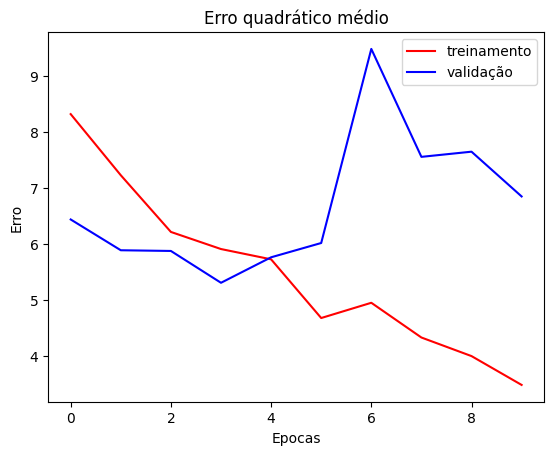

In [13]:
def plot_loss(history):
    loss = history['loss']
    valloss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label = 'treinamento')
    plt.plot(epochs, valloss, 'b', label = 'validação')
    plt.title('Erro quadrático médio')
    plt.xlabel('Epocas')
    plt.ylabel('Erro')
    plt.legend()

import matplotlib.pyplot as plt
import numpy as np

plot_loss(history.history)

np.min(history.history['loss'])

In [ ]:
# 1 = 7.17478084564209
# vec - off
# norm - off
# std - off

#2 = 0.05414246767759323
# vec - on
# norm - off
# std - off

#3 = 6.575065612792969
# vec - off
# norm - on
# std - off

#4 = 0.02096634916961193
# vec - off
# norm - off
# std - on

#5 = 0.021364504471421242
# vec - off
# norm - on
# std - on

#6 = 0.05872812122106552
# vec - on
# norm - on
# std - on